In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import neighbors
from sklearn.model_selection import cross_val_score

import warnings
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Challenge 3.1.4

In [2]:
# Loading dataset
df_raw = pd.read_csv('datafiles/table_8_offenses_known_to_law_enforcement_california_by_city_2013.csv',
                     encoding='iso-8859-1')

In [3]:
df_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
0,Adelanto,"31,165",198,2,NaN,15,52,129,886,381,372,133,17
1,Agoura Hills,"20,762",19,0,NaN,2,10,7,306,109,185,12,7
2,Alameda,"76,206",158,0,NaN,10,85,63,"1,902",287,"1,285",330,17
3,Albany,"19,104",29,0,NaN,1,24,4,557,94,388,75,7
4,Alhambra,"84,710",163,1,NaN,9,81,72,"1,774",344,"1,196",234,7


In [4]:
# Renaming columns
df_raw.columns = ['City','Population','Violent_Crime','Murder','Rape_a','Rape_b','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 13 columns):
City              462 non-null object
Population        462 non-null object
Violent_Crime     462 non-null object
Murder            462 non-null int64
Rape_a            0 non-null float64
Rape_b            462 non-null int64
Robbery           462 non-null object
Assault           462 non-null object
Property_crime    462 non-null object
Burglary          462 non-null object
Larceny_theft     462 non-null object
Auto_theft        462 non-null object
Arson             462 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 47.0+ KB


## Generating dataset for analysis

In [6]:
# Dropping the revised rape definition column because it contains no info.
df1 = df_raw.drop(['Rape_a'], axis=1)

In [7]:
#Changing non-null object columns to ints for analysis

int_cols = ['Population','Violent_Crime','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

# For column that has data stored as a string instead of a number, remove the comma,= and convert it to a number.
for x in int_cols:
    df1[x] = df_raw[x].str.replace(",","")
    df1[x] = pd.to_numeric(df1[x])

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 12 columns):
City              462 non-null object
Population        462 non-null int64
Violent_Crime     462 non-null int64
Murder            462 non-null int64
Rape_b            462 non-null int64
Robbery           462 non-null int64
Assault           462 non-null int64
Property_crime    462 non-null int64
Burglary          462 non-null int64
Larceny_theft     462 non-null int64
Auto_theft        462 non-null int64
Arson             462 non-null int64
dtypes: int64(11), object(1)
memory usage: 43.4+ KB


In [9]:
df1[df1['Population'] > 800000]

,City,Population,Violent_Crime,Murder,Rape_b,Robbery,Assault,Property_crime,Burglary,Larceny_theft,Auto_theft,Arson
234,Los Angeles,3878725,16524,251,764,7885,7624,85844,15728,55734,14382,1430
353,San Diego,1349306,5303,39,316,1456,3492,31728,6355,19230,6143,178
356,San Francisco,833863,7064,48,161,4202,2653,48324,5931,36527,5866,227
360,San Jose,992143,3215,38,270,1095,1812,25510,5173,12411,7926,133


In [10]:
# For simplicity sake, only looking at cities with a population under 800,000
df1 = df1.drop([234,353,282,356,360])

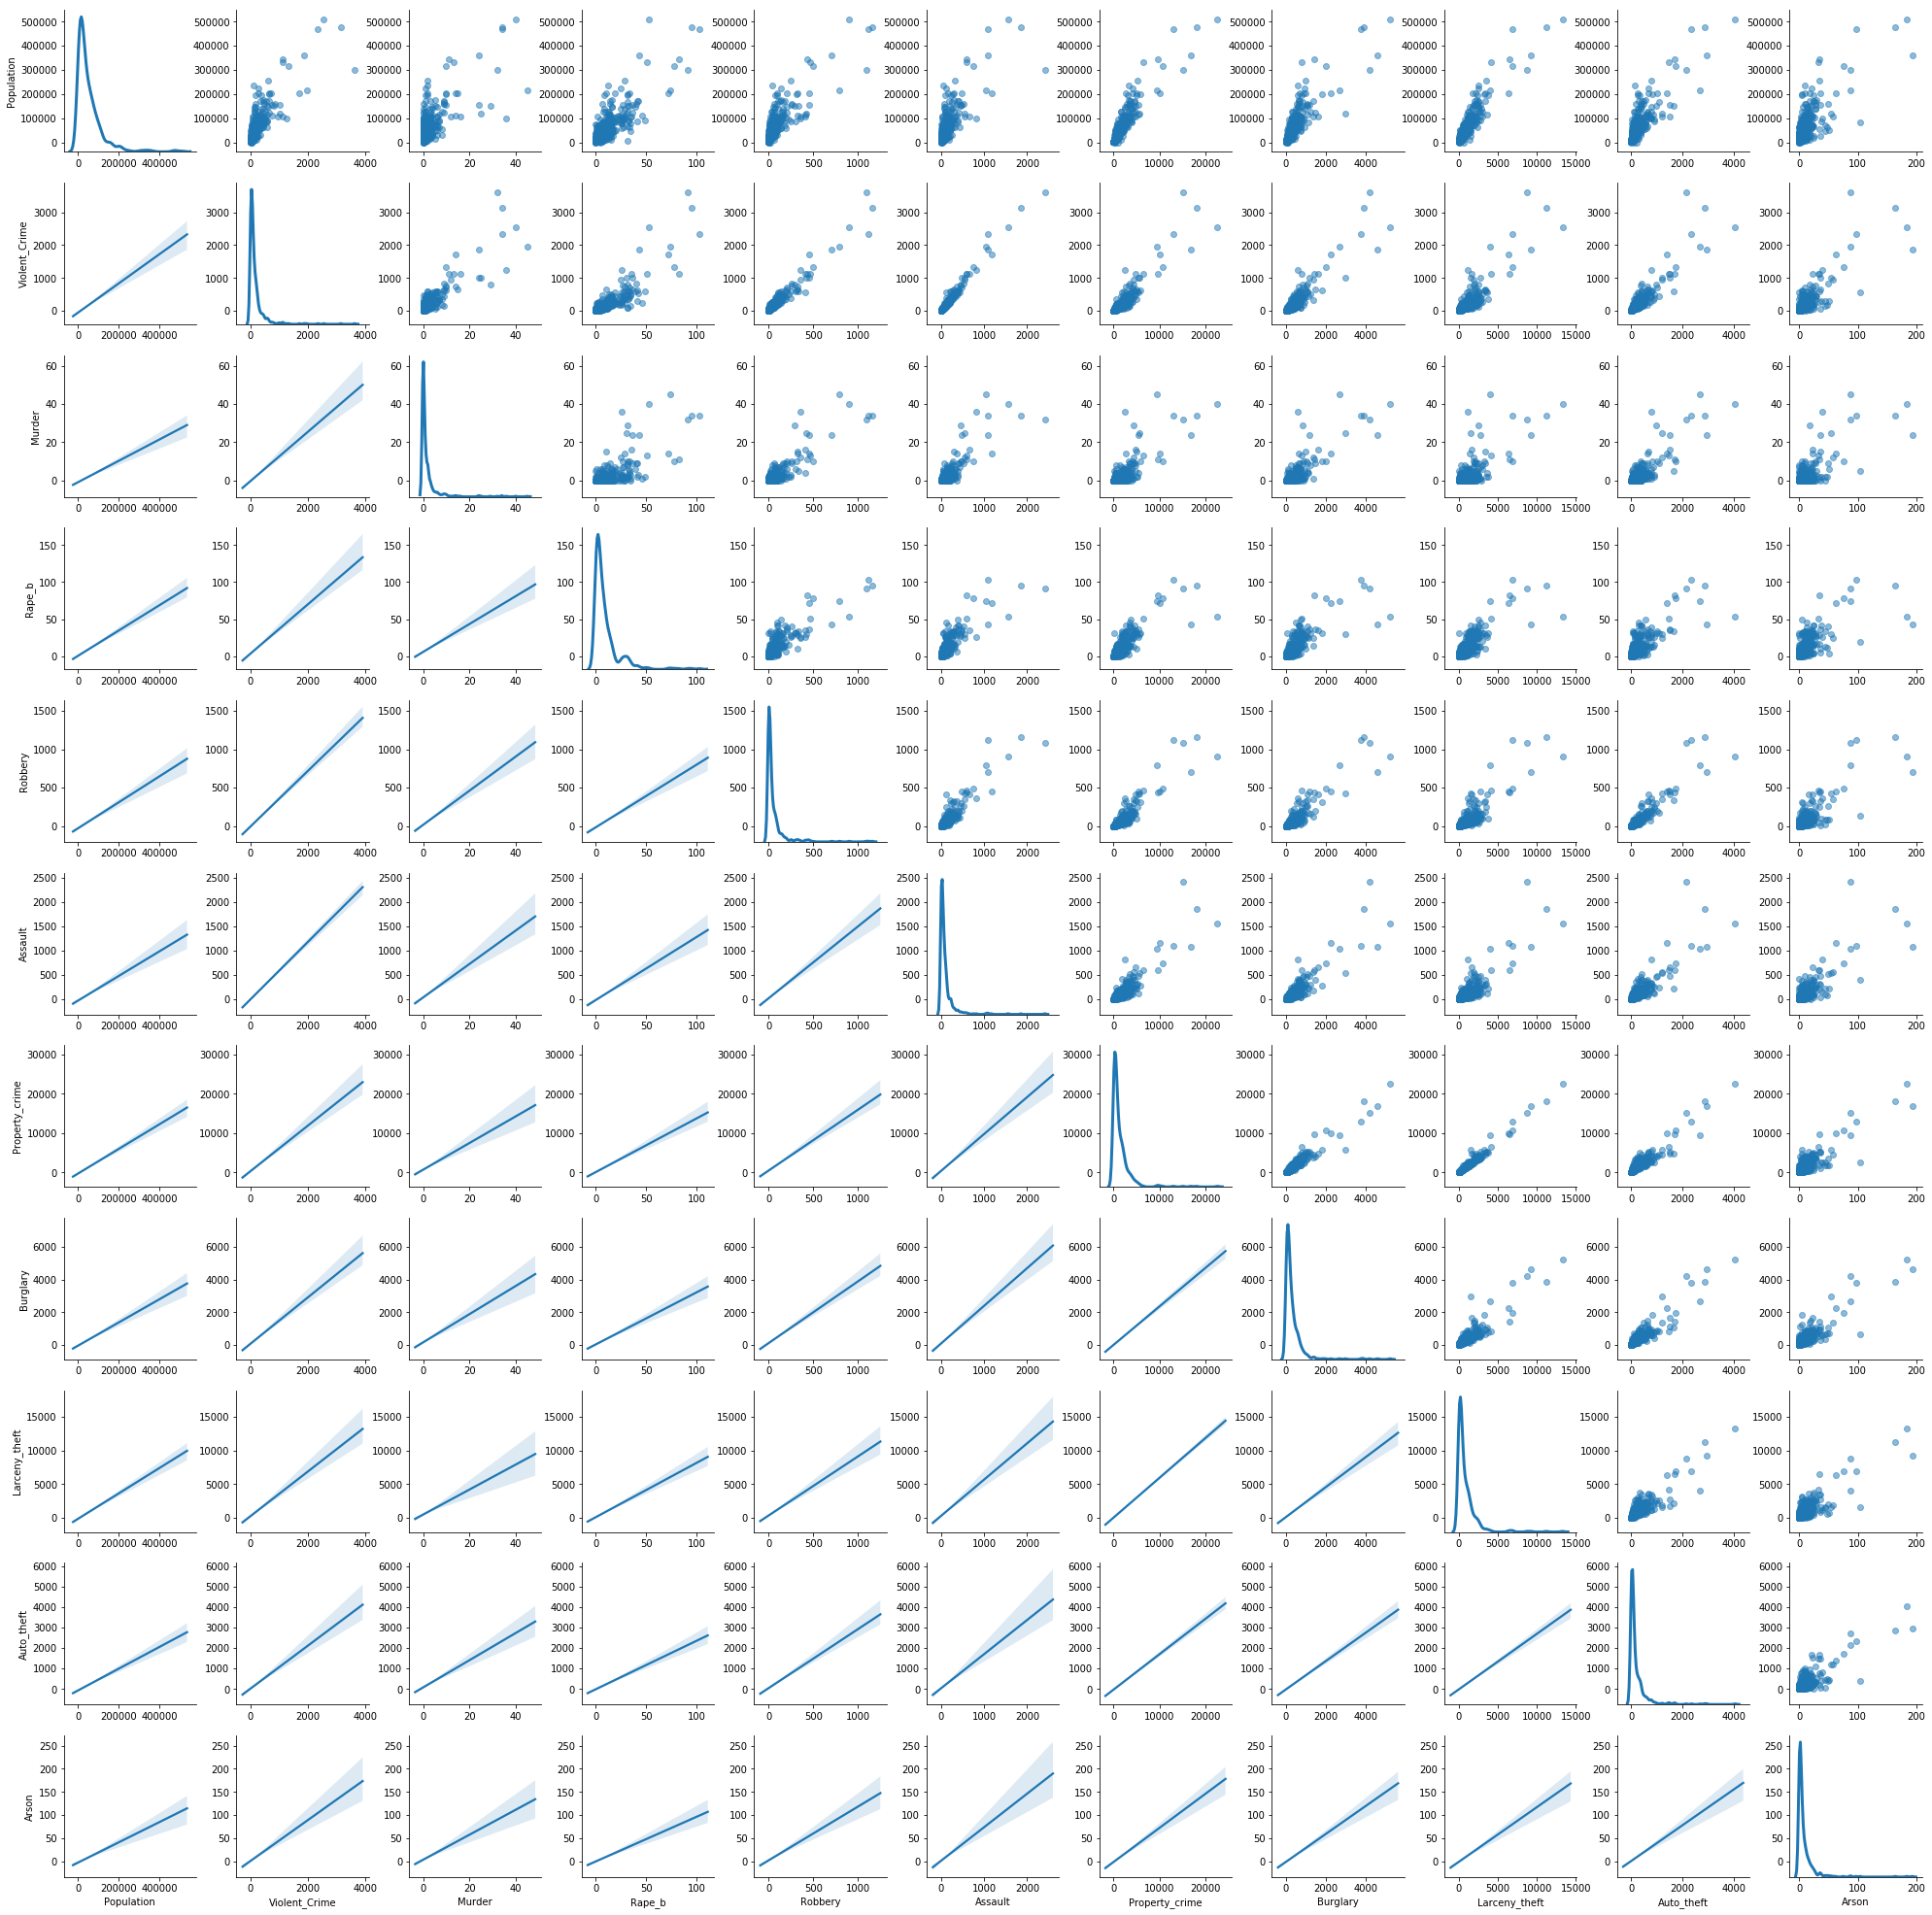

In [11]:
df_explore = df1.loc[:, 'Population':'Arson'].dropna()

# Scatterplot matrix
g = sns.PairGrid(df_explore, diag_sharey=False)

#Scatterplots
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing linear relationship of two variables
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Univariate distribtuion of the variables
g.map_diag(sns.kdeplot, lw=3)

plt.show()

Looking at Property crime, its relationship between the other features look linear for the most part.  THis satisfied the linear regression model's assumption of linear relationship.

# OLS Model

Let's create on OLS model that best predicts for property crime.

In [12]:
df2 = df1.loc[:,['Population','Violent_Crime','Property_crime']]

In [13]:
y = df1.Property_crime.values.reshape(-1, 1)
# What does values.reshape do?

X = df1.loc[:,['Population','Violent_Crime']]

## Testing assumptions

In [14]:
# Testing for the assumption of low collinearity

correlation_matrix = df2.corr()
display(correlation_matrix)

,Population,Violent_Crime,Property_crime
Population,1.000000,0.822193,0.918105
Violent_Crime,0.822193,1.000000,0.920197
Property_crime,0.918105,0.920197,1.000000


Hmm the collinearity is actually pretty high, which is not surprising.  A more populous place can lead to more crime.

## Fit the OLS model - Using sklearn

In [15]:
# Fit a linear model with all 10 features.
regr = linear_model.LinearRegression()
regr.fit(X, y)

# Save predicted values.
Y_pred = regr.predict(X)
print('R-squared regression:', regr.score(X, y))

# Print results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)

R-squared regression: 0.927288643638

Coefficients: 
 [[ 0.01698854  3.20940727]]

Intercept: 
 [-64.75684642]


A very high $R^2$.  This is a good indication that the model is grossly overfitted.  

In [16]:
# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=1)

# Reduce X to R(X) and regress on y.
pls1.fit(X, y)

# Save predicted values.
Y_PLS_pred = pls1.predict(X)
print('R-squared PLSR:', pls1.score(X, y))

# Print results
print('\nCoefficients: \n', pls1.coef_)

R-squared PLSR: 0.927278618557

Coefficients: 
 [[ 1128.89662935]
 [ 1131.46930706]]


Still a high $R^2$. Again, not surprising because of the high collinearity between variables.

## Testing assumptions

#### Multivariate normality

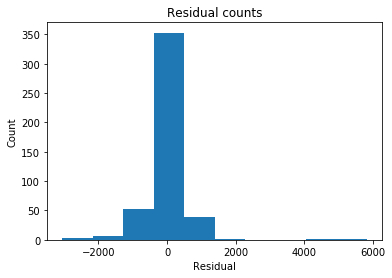

In [17]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df1.Property_crime

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Homoscedasticity

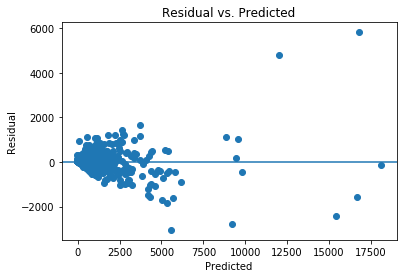

In [18]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

The residual plot does look pretty even above and below 0, but we can see that the model becomes less accurate with increased property crimes.


# Testing model on NY 2013 crime data

In [19]:
# Loading dataset
df_ny = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv')

# Removing info columns at head and tail of dataframe
df_ny = df_ny[4:352]

# Renaming columns
df_ny.columns = ['City','Population','Violent_Crime','Murder','Rape_a','Rape_b','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

# Resetting index
df_ny.reset_index(drop=True)

# Dropping the revised rape definition column because it contains no info.
df_ny = df_ny.drop(['Rape_a'], axis=1)

#Changing strings to ints for analysis

int_cols = ['Population','Violent_Crime','Murder', 'Rape_b','Robbery','Assault',
                  'Property_crime','Burglary','Larceny_theft','Auto_theft','Arson']

# For column that has data stored as a string instead of a number, remove '$', the comma, and convert it to a number.
for x in int_cols:
    df_ny[x] = df_ny[x].str.replace(",","")
    df_ny[x] = pd.to_numeric(df_ny[x])
    
# For consistency, dropping cities with populations over 800,000.
df_ny = df_ny.drop(df_ny[df_ny.Population > 800000].index)

df_ny = df_ny.dropna()

df_ny = df_ny.reset_index(drop=True)

In [20]:
df_ny.head()

,City,Population,Violent_Crime,Murder,Rape_b,Robbery,Assault,Property_crime,Burglary,Larceny_theft,Auto_theft,Arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.0
3,Allegany Village,1781,3,0,0,0,3,10,0,10,0,0.0
4,Amherst Town,118296,107,1,7,31,68,2118,204,1882,32,3.0


In [21]:
# Setting up X and Ys
X_ny = df_ny.loc[:,['Population','Violent_Crime']]
y_ny = df_ny.Property_crime.values.reshape(-1,1)

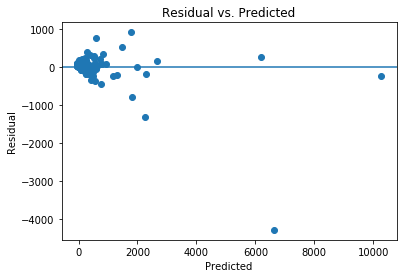

In [22]:
# Test model on New York data.
test_pred = regr.predict(X_ny).ravel()
actual = df_ny['Property_crime']

# Calculate the error, also called the residual.
residual = actual - test_pred

# Generating residuals and predicted scatterplot
plt.scatter(test_pred, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Not bad.  There is one datapoint that was grossly underestimated.  We are looking at two metropolitan cities so it's not surprising that the model is a good fit.

## Fit OLS model - Using statmodels

In [23]:
# Using statmodels ols function so we can look at t-statistics and p-values.

# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form

# Starting with all the features.
linear_formula = 'Property_crime ~ Population + Violent_Crime'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df1).fit()

In [24]:
lm.params

Intercept       -64.756846
Population        0.016989
Violent_Crime     3.209407
dtype: float64

In [25]:
lm.pvalues

Intercept        8.164422e-02
Population       1.651781e-75
Violent_Crime    5.878919e-78
dtype: float64

Only population, burglary, larceny_theft, and auto_theft are significant. Actually, what does a pvalue of 0.000000e+00 mean? I assume that means it is highly significant.

In [26]:
lm.rsquared

0.92728864363770136

High $R^2$ signifies overfitting.

In [27]:
lm.conf_int()

,0,1
Intercept,-137.681275,8.167582
Population,0.015500,0.018477
Violent_Crime,2.934614,3.484200


In [28]:
# Removing variables with weak p values
linear_formula2 = 'Property_crime ~ Violent_Crime'

# Fit the model
lm2 = smf.ols(formula=linear_formula2, data=df1).fit()

In [29]:
lm2.params

Intercept        359.581563
Violent_Crime      5.787313
dtype: float64

In [30]:
lm2.pvalues

Intercept         5.321296e-14
Violent_Crime    1.901578e-187
dtype: float64

In [31]:
lm2.rsquared

0.84676262337660146

In [32]:
lm2.conf_int()

,0,1
Intercept,268.618115,450.545012
Violent_Crime,5.560495,6.014131


Just using violent crime is a good predictor for propoerty crime in this model.  With just one variable and the lower $R^2$, there is less of a risk of overfitting.

## Building KNN Regression - using sklearn

### Unweighted

In [33]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [34]:
score = cross_val_score(knn, X, y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.79 (+/- 0.12)


In [35]:
score

array([ 0.86606362,  0.71521609,  0.82941461,  0.78591296,  0.72871803])

### Weighted

In [36]:
# Using weights
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

In [37]:
score = cross_val_score(knn_w, X, y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Weighted Accuracy: 0.80 (+/- 0.10)


In [38]:
score

array([ 0.84666037,  0.79831516,  0.77569382,  0.85941051,  0.7292897 ])

The mean accuracy of the weighted scores from cross validation is better.

## Conclusion

The $R^2$ of the models are pretty similar, around 0.79 - 0.85, with OLS having the highest $R^2$. 

A KNN regression is a non-parametric modelling method, and thus more of a "black box". It does not assume a linear relationship, for example. KNN is better at considering local effects in the dataset. However, KNN is often more complex to understand and interpret.
OLS is a parametric modelling method.  We can use the coefficents of the parameters to consider the impact that the dependent variables have on the independent variable.  

# Challenge 3.3.4 Advanced regression

Now that you have two new regression methods at your fingertips, it's time to give them a spin. In fact, for this challenge, let's put them together! 

Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

Vanilla logistic regression
Ridge logistic regression
Lasso logistic regression

If you're stuck on how to begin combining your two new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

Record your work and reflections in a notebook to discuss with your mentor.



In [96]:
df1.describe()

,Population,Violent_Crime,Murder,Rape_b,Robbery,Assault,Property_crime,Burglary,Larceny_theft,Auto_theft,Arson,murder_bi
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,53038.240700,184.919037,2.043764,9.568928,62.308534,110.997812,1429.765864,332.980306,880.997812,215.787746,8.960613,0.450766
std,65750.153871,356.254024,5.263063,13.753794,132.877165,213.191830,2240.556455,550.624854,1343.886423,411.914445,19.127647,0.498115
min,115.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,11803.000000,27.000000,0.000000,2.000000,5.000000,17.000000,278.000000,75.000000,159.000000,21.000000,1.000000,0.000000
50%,31134.000000,75.000000,0.000000,5.000000,21.000000,50.000000,702.000000,173.000000,436.000000,77.000000,3.000000,0.000000
75%,70075.000000,194.000000,2.000000,12.000000,64.000000,118.000000,1830.000000,390.000000,1160.000000,241.000000,10.000000,1.000000
max,508876.000000,3622.000000,45.000000,103.000000,1158.000000,2411.000000,22584.000000,5223.000000,13304.000000,4057.000000,193.000000,1.000000


Can we predict whether or not there would be a murder in a city?

In [97]:
# Coding Murder to be binary 
df1['murder_bi'] = np.where(df1['Murder']>=1,1,0)

In [98]:
# Dropping Violent_Crime and Property_crime because they are the sum of some of the other categories.
df3 = df1.drop(['City','Violent_Crime','Property_crime','Murder'], axis=1)

In [99]:
df3.head()

,Population,Rape_b,Robbery,Assault,Burglary,Larceny_theft,Auto_theft,Arson,murder_bi
0,31165,15,52,129,381,372,133,17,1
1,20762,2,10,7,109,185,12,7,0
2,76206,10,85,63,287,1285,330,17,0
3,19104,1,24,4,94,388,75,7,0
4,84710,9,81,72,344,1196,234,7,1


In [100]:
#Pull 30% of cases and store it for testing
test = df3.sample(frac = 0.3, random_state=4566)

#Training data is the rest of the data (70%).
train = df3.drop(test.index)

### Vanilla logistic regression

In [101]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [102]:
# Declare predictors and outcome
X = train.loc[:,'Population':'Arson']
y = train['murder_bi']

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(y, X)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.431785
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              murder_bi   No. Observations:                  320
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            8
Date:                Mon, 05 Mar 2018   Pseudo R-squ.:                  0.3736
Time:                        14:28:44   Log-Likelihood:                -138.17
converged:                       True   LL-Null:                       -220.58
                                        LLR p-value:                 1.569e-31
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Population     1.849e-06   8.21e-06      0.225      0.822   -1.42e-05    1.79e-05
Rape_b            0.

In [103]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(y, pred_y_statsmod)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by admission status
col_0        0   1
murder_bi         
0          156  18
1           47  99

 Percentage accuracy
0.796875


In [112]:
# Now testing model with test data!
y_test = test['murder_bi']
X_test = test.loc[:,'Population':'Arson']

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_test)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(y_test, pred_y_statsmod)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))

ValueError: shapes (137,8) and (9,) not aligned: 8 (dim 1) != 9 (dim 0)

Not sure what's going on here...

### Ridge Regression
The default penalty for sklearn Logistic regression is l2.  How do you run a "vanilla" Logistic Regression using SKlearn?

In [110]:
# Declare a logistic regression classifier.
rlr = LogisticRegression(penalty='l2', C=1e9)

# Fit the model.
fit = rlr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = rlr.predict(X)

print('\n Accuracy matrix')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(rlr.score(X, y))

Coefficients
[[ -9.85087997e-06   4.54450297e-03   7.80834592e-03   2.06976120e-03
   -3.46981347e-04  -2.92028210e-04   5.53237599e-03  -3.41465919e-04]]
[-0.00269938]

 Accuracy matrix
murder_bi   0    1
row_0             
0          92   18
1          82  128

 Percentage accuracy
0.6875


In [111]:
print('\n Percentage accuracy')
print(rlr.score(X_test, y_test))


 Percentage accuracy
0.671532846715


The $R^2$s for the test and the training data are pretty similar, indicating that the model is likely accurate. 

### Lasso Regression

In [108]:
# Declare a logistic regression classifier.
llr = LogisticRegression(penalty='l1', C=1e9)
y = train['murder_bi']
X = train.loc[:,'Population':'Arson']

# Fit the model.
fit = llr.fit(X, y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = llr.predict(X)

print('\n Accuracy matrix')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(llr.score(X, y))

print('\n Percentage accuracy for test data')
print(llr.score(X_test, y_test))

Coefficients
[[  1.81110105e-06   1.49630595e-01   5.91161180e-03   2.61959047e-03
    2.30313087e-03  -1.22582558e-03   6.67533249e-03  -1.75425504e-02]]
[-2.04751546]

 Accuracy matrix
murder_bi    0   1
row_0             
0          156  47
1           18  99

 Percentage accuracy
0.796875

 Percentage accuracy for test data
0.802919708029
